<a href="https://colab.research.google.com/github/beliabaez/CE888_2020/blob/master/Lab7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dogs vs. Cats 

In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

![alt text](https://miro.medium.com/max/3000/1*bhFifratH9DjKqMBTeQG5A.gif)

Ref: https://medium.com/@thegrigorian/rolling-in-the-deep-cnn-c8d3f7108c8c

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "beliabaez" # username from the json file
os.environ['KAGGLE_KEY'] = "45f2130868dac04e2b8e87a2c948712d" # key from the json file
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia # api copied from kaggle

 99% 2.28G/2.29G [00:50<00:00, 46.1MB/s]
100% 2.29G/2.29G [00:50<00:00, 49.1MB/s]


In [5]:
# Upload data
from zipfile import ZipFile

file_name = "/content/chest-xray-pneumonia.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

In [10]:
print('total training normal chest:', len(os.listdir("/content/chest_xray/train/NORMAL")))
print('total training pneumonia chest:', len(os.listdir("/content/chest_xray/train/PNEUMONIA")))
print('total validation normal chest:', len(os.listdir("/content/chest_xray/val/NORMAL")))

print('total validation pneumonia chest:', len(os.listdir("/content/chest_xray/val/PNEUMONIA")))
print('total test pneumonia chest:', len(os.listdir("/content/chest_xray/test/PNEUMONIA")))
print('total test normal chest:', len(os.listdir("/content/chest_xray/test/NORMAL")))

total training normal chest: 1341
total training pneumonia chest: 3875
total validation normal chest: 8
total validation pneumonia chest: 8
total test pneumonia chest: 390
total test normal chest: 234


In [11]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Using TensorFlow backend.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)  

In [12]:
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Using ImageDataGenerator to read images from directories
As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. Keras has a module with image-processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator,which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/content/chest_xray/train",
                                                    target_size=(150, 150), 
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory("/content/chest_xray/val",
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely,like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring anepoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10)

Epoch 1/30
100/100 [==============================] - 30s 296ms/step - loss: 0.4730 - acc: 0.7809 - val_loss: 0.5338 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 24s 244ms/step - loss: 0.2625 - acc: 0.8840 - val_loss: 0.7958 - val_acc: 0.6250
Epoch 3/30
100/100 [==============================] - 24s 241ms/step - loss: 0.1883 - acc: 0.9190 - val_loss: 0.8697 - val_acc: 0.5625
Epoch 4/30
100/100 [==============================] - 23s 233ms/step - loss: 0.1458 - acc: 0.9450 - val_loss: 0.3664 - val_acc: 0.8125
Epoch 5/30
100/100 [==============================] - 24s 243ms/step - loss: 0.1245 - acc: 0.9533 - val_loss: 0.6739 - val_acc: 0.7500
Epoch 6/30
100/100 [==============================] - 24s 240ms/step - loss: 0.1281 - acc: 0.9520 - val_loss: 1.0621 - val_acc: 0.5625
Epoch 7/30
100/100 [==============================] - 24s 239ms/step - loss: 0.1005 - acc: 0.9620 - val_loss: 0.3998 - val_acc: 0.8125
Epoch 8/30
100/100 [==============================] - 2

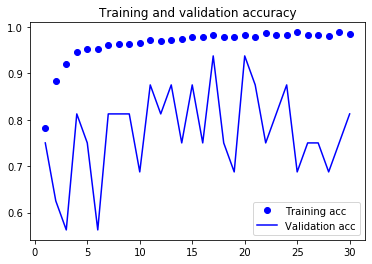

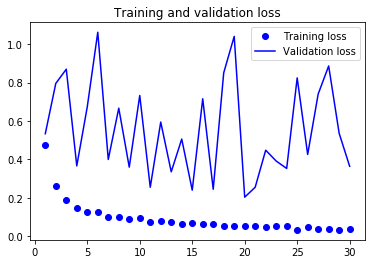

In [23]:
model.save('cats_and_dogs_small_1.h5')

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Convolutional Networks with Dropout

![alt text](https://camo.githubusercontent.com/ee6fa1073247cd2c3d241300caf110d7a7541bc5/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f3830302f312a4972644a355067684439596f4f7956415137334d4a772e676966)

Ref: https://github.com/mneha4/Training-Neural-Nets---Guidelines

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/content/chest_xray/val",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory("/content/chest_xray/val",
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 41s 406ms/step - loss: 0.6724 - acc: 0.5700 - val_loss: 0.6213 - val_acc: 0.6250
Epoch 2/20
100/100 [==============================] - 40s 400ms/step - loss: 0.6171 - acc: 0.6425 - val_loss: 0.5239 - val_acc: 0.7500
Epoch 3/20
100/100 [==============================] - 40s 400ms/step - loss: 0.5577 - acc: 0.7200 - val_loss: 0.4115 - val_acc: 0.8125
Epoch 4/20
100/100 [==============================] - 40s 399ms/step - loss: 0.4757 - acc: 0.7806 - val_loss: 0.5621 - val_acc: 0.6250
Epoch 5/20
100/100 [==============================] - 40s 400ms/step - loss: 0.4240 - acc: 0.8244 - val_loss: 0.4140 - val_acc: 0.7500
Epoch 6/20
100/100 [==============================] - 40s 400ms/step - loss: 0.3688 - acc: 0.8450 - val_loss: 0.6111 - val_acc: 0.6875
Epoch 7/20
100/100 [==============================] - 40s 400ms/step - loss: 0.3352 - acc: 0.8719 - val_loss: 